🎯 Why It’s Needed
Most real-world queries are:
- Multifaceted (require multiple types of information)
- Ambiguous or incomplete (need refinement)
- Open-ended (don’t map to a single document or source)

🔍 This makes retrieving from a single vector DB insufficient.

Instead, we want an agent that can:

- Decide what to fetch from where (retrieval planning)
- Retrieve content from multiple tools (e.g., Wikipedia, PDFs, APIs, SQL)
- Evaluate and merge that context
- Produce a single human-like response

In [4]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders.youtube import YoutubeLoader
from langchain_community.document_loaders import ArxivLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, END

In [1]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o-mini")

In [2]:
def load_text_retriever(file_path):
    docs = TextLoader(file_path, encoding="utf-8").load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = splitter.split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    return vs.as_retriever()

def load_youtube_retriever():
    # Mocked YouTube transcript text
    content = """
    This video explains how agentic AI systems rely on feedback loops, memory, and tool use.
    It compares them to traditional pipeline-based LLMs. Temporal reasoning and autonomous tasking are emphasized.
    """
    doc = Document(page_content=content, metadata={"source": "youtube"})
    vectorstore = FAISS.from_documents([doc], OpenAIEmbeddings())
    return vectorstore.as_retriever()



def wikipedia_search(query: str) -> str:
    print("🌐 Searching Wikipedia...")
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())(query)

def arxiv_search(query: str) -> str:
    print("📄 Searching ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content for doc in results[:2]) or "No relevant papers found."

In [5]:
text_retriever = load_text_retriever("research_notes.txt")
youtube_retriever = load_youtube_retriever()

In [6]:
### state
class MultiSourceRAGState(BaseModel):
    question: str
    text_docs: List[Document] = []
    yt_docs: List[Document] = []
    wiki_context: str = ""
    arxiv_context: str = ""
    final_answer: str = ""

In [7]:
### Retrieval Nodes
def retrieve_text(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = text_retriever.invoke(state.question)
    return state.model_copy(update={"text_docs": docs})

def retrieve_yt(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = youtube_retriever.invoke(state.question)
    return state.model_copy(update={"yt_docs": docs})

def retrieve_wikipedia(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = wikipedia_search(state.question)
    return state.model_copy(update={"wiki_context": result})

def retrieve_arxiv(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = arxiv_search(state.question)
    return state.model_copy(update={"arxiv_context": result})

In [8]:
## synthesize
def synthesize_answer(state: MultiSourceRAGState) -> MultiSourceRAGState:
    
    context = ""

    context += "\n\n[Internal Docs]\n" + "\n".join([doc.page_content for doc in state.text_docs])
    context += "\n\n[YouTube Transcript]\n" + "\n".join([doc.page_content for doc in state.yt_docs])
    context += "\n\n[Wikipedia]\n" + state.wiki_context
    context += "\n\n[ArXiv]\n" + state.arxiv_context

    prompt = f"""You have retrieved relevant context from multiple sources. Now synthesize a complete and coherent answer.

Question: {state.question}

Context:
{context}

Final Answer:"""

    answer = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"final_answer": answer})

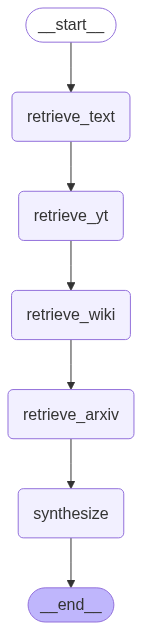

In [9]:
builder = StateGraph(MultiSourceRAGState)

builder.add_node("retrieve_text", retrieve_text)
builder.add_node("retrieve_yt", retrieve_yt)
builder.add_node("retrieve_wiki", retrieve_wikipedia)
builder.add_node("retrieve_arxiv", retrieve_arxiv)
builder.add_node("synthesize", synthesize_answer)

builder.set_entry_point("retrieve_text")
builder.add_edge("retrieve_text", "retrieve_yt")
builder.add_edge("retrieve_yt", "retrieve_wiki")
builder.add_edge("retrieve_wiki", "retrieve_arxiv")
builder.add_edge("retrieve_arxiv", "synthesize")
builder.add_edge("synthesize", END)

graph = builder.compile()
graph

In [11]:
question = "What are transformer agents and how are they evolving in recent research?"
state = MultiSourceRAGState(question=question)
result = graph.invoke(state)

print("✅ Final Answer:\n")
print(result["final_answer"])


🌐 Searching Wikipedia...
📄 Searching ArXiv...


UnexpectedEmptyPageError: Page of results was unexpectedly empty (https://export.arxiv.org/api/query?search_query=What+are+transformer+agents+and+how+are+they+evolving+in+recent+research%3F&id_list=&sortBy=relevance&sortOrder=descending&start=1&max_results=100)